In [24]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from catboost import CatBoostRegressor
import scipy as sp

from scipy.fftpack import fft
from tsfresh.feature_extraction import feature_calculators

from scipy import signal

import pywt

import librosa

import gc
%matplotlib inline

In [2]:
%time
train_df = pd.read_csv(os.path.join("../../input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.4 µs


In [3]:

def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    #univeral threshold
    uthresh = 10
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

def create_features(seg):
    X = pd.DataFrame(index=[0], dtype=np.float64)
    
    xc = seg["acoustic_data"]
    
    z = xc + np.random.normal(0, 0.5, 150000)
    z = z - z.median()

    window_size = 50
    xc_rolled = z.rolling(window_size)
    xc_rolled_var = xc_rolled.var().dropna()
    window_str = str(window_size)
    
    X["rolledVar_"+window_str+"_quantile20"] =xc_rolled_var.quantile(0.2)
    
    denoised = denoise_signal_simple(z)
    X['num_peaks_2_denoise'] = feature_calculators.number_peaks(denoised, 2)
    
    mfcc = librosa.feature.mfcc(z.values)
    mfcc_mean = mfcc.mean(axis=1)
    X['var_mfcc_mean18'] = mfcc_mean[18]
    X['var_mfcc_mean4'] = mfcc_mean[4]
    
    return X

In [4]:
from joblib import Parallel,delayed
def generate_train(seg_id,sample):
    train = create_features(sample)
    train["seg_id"] = seg_id
    train["target"] = sample['time_to_failure'].values[-1]
    return train
def add_features_train(train_df,segments):
    result = Parallel(n_jobs=4, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")(
        delayed(generate_train)(seg_id,train_df.iloc[seg_id*rows:seg_id*rows+rows])
        for seg_id in tqdm_notebook(segments)
    )
    data = [r.values for r in result]
    data = np.vstack(data)
    train = pd.DataFrame(data,columns=result[0].columns)
    train.set_index('seg_id',inplace=True)
    return train


In [5]:
def generate_test(file):
    seg_id = file[:-4]
    segment = pd.read_csv(os.path.join("../../input",file),dtype={'acoustic_data': np.int16})
    test = create_features(segment)
    test["seg_id"] = seg_id
    return test
def add_features_test():
    segment_names = [file for file in os.listdir("../../input") if file.startswith("seg")]
    result = Parallel(n_jobs=4, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")(
        delayed(generate_test)(file)
        for file in tqdm_notebook(segment_names)
    )
    data = [r.values for r in result]
    data = np.vstack(data)
    test = pd.DataFrame(data,columns=result[0].columns)
    test.set_index('seg_id',inplace=True)
    return test

In [6]:
rows = 150000
segments = list(range(int((np.floor(train_df.shape[0]))/ rows)))

train_X = add_features_train(train_df,segments)


In [7]:
train_y = train_X["target"].copy()
train_X.drop(columns=["target"],inplace=True)

In [8]:
test_df = add_features_test()

In [11]:
#Finding groups for each quakes
quakes = (train_y - train_y.shift())>0.5
eq_groups = pd.DataFrame(train_y.copy())
eq_groups["group"] = 0
eq_groups.loc[quakes,"group"] += 1
eq_groups["group"] = eq_groups["group"].cumsum()
eq_groups.drop(columns=["target"],inplace=True)
eq_groups = eq_groups.values.reshape(eq_groups.shape[0],)

In [12]:
#eliminate quakes from training
train_y_eliminated = train_y[~quakes].copy()
train_X_eliminated = train_X[~quakes].copy()
eq_groups_el = eq_groups[~quakes]

In [13]:
n_fold = 3

folds = KFold(n_splits=n_fold,shuffle=True,random_state=1337)
params = {'num_leaves': 4,
      'min_data_in_leaf': 5,
      'objective':'fair',
      'max_depth': -1,
      'learning_rate': 0.02,
      "boosting": "gbdt",
      'boost_from_average': True,
      "feature_fraction": 0.9,
      "bagging_freq": 1,
      "bagging_fraction": 0.5,
      "bagging_seed": 0,
      "metric": 'mae',
      "verbosity": -1,
      'max_bin': 500,
      'reg_alpha': 0,
      'reg_lambda': 0,
      'seed': 0,
      }


In [14]:
def train(train_X,train_y,test_df,params,folds):
    features_importance = pd.DataFrame({"features":train_X.columns,
                                        "importance":np.zeros(train_X.columns.shape[0])})
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])

    for train_idx,val_idx in folds.split(train_X,train_y):
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
        model.fit(X_train,y_train,
                  eval_set=[(X_val,y_val),(X_train,y_train)], 
                  verbose=5000,
                  early_stopping_rounds=1000)

        oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
        features_importance["importance"] += model.feature_importances_
        predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_)
    return oof,predictions,features_importance
'''This is cricial to use to training only earthquakes only with similiar mean time to failure'''
np.random.seed(1337)
mask = np.isin(eq_groups_el,[2, 7, 0, 4, 11, 13, 9, 1, 14, 10])
oof,predictions,features_importance = train(train_X_eliminated[mask],train_y_eliminated[mask],test_df.astype(float),params,folds)

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[179]	training's l1: 1.83116	valid_0's l1: 1.89214
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[233]	training's l1: 1.81689	valid_0's l1: 1.8698
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[616]	training's l1: 1.6732	valid_0's l1: 1.98496


In [15]:
print('\nMAE: ', mean_absolute_error(train_y_eliminated[mask], oof))


MAE:  1.9156262200455132


In [ ]:
features_importance["importance"] = features_importance["importance"]/3

final_pred = predictions.copy()
final_pred["time_to_failure"] = predictions["time_to_failure"]/3
final_pred["seg_id"] = test_df.index.values
# ax = sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))
final_pred.to_csv("../../submissions/kfolds/top_solutions/first_place_solution.csv",index=False)

In [ ]:
train_X_eliminated[mask]["rolledVar_50_quantile20"].plot()
train_y_eliminated[mask].plot()

In [ ]:
train_y_eliminated[mask].reset_index(drop=True).plot()

How did they choose those specific quakes as training? Based on KS test they choose some of the quakes, sampled it and they done KS statistic. After that they plot sampled statistics with dependence of the mean time_to_failure. Those with the lower statistic are better, so they choose quakes with mean time around 6.2-6.3.

In [19]:
ks_stats = {}
p_vals = {}
means = []
for it in range(10000):
#     sample = train
    mask = np.isin(eq_groups,np.random.choice(10, 16))
    sample = train_X[mask].sample(600,random_state=it)
    sample_y = train_y[mask].sample(600,random_state=it)
    means.append(sample_y.mean())
    for feat in sample.columns:
        ks_test = sp.stats.ks_2samp(sample[feat],test_df[feat])
        if feat not in ks_stats.keys():
            ks_stats[feat]=[ ks_test.statistic]
            p_vals[feat]=[ ks_test.pvalue]
        else:
            ks_stats[feat].append(ks_test.statistic)
            p_vals[feat].append(ks_test.pvalue)

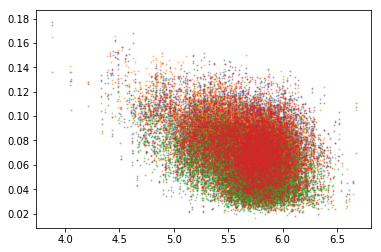

In [21]:
for feat in ks_stats.keys():
    plt.scatter(means,ks_stats[feat],alpha=0.4,s=1)

They also trained SVR, and nn similiar way. Solution reproduced only on LGBM gave private score 2.27739
and public 1.74486